In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import string
import sqlite3
import matplotlib.pyplot as plt
import datetime
conn = sqlite3.connect('./zippedData/im.db')
TheNumbers = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [49]:
punct = '$,'   # `|` is not present here
money_to_num = str.maketrans(dict.fromkeys(punct, ''))

#stripping dollar-sign and commas from relevant objects
TheNumbers['worldwide_gross'] = '|'.join(TheNumbers['worldwide_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['domestic_gross'] = '|'.join(TheNumbers['domestic_gross'].tolist()).translate(money_to_num).split('|')
TheNumbers['production_budget'] = '|'.join(TheNumbers['production_budget'].tolist()).translate(money_to_num).split('|')
#converting number strings to int64 types
TheNumbers['worldwide_gross'] = TheNumbers['worldwide_gross'].astype(np.int64)
TheNumbers['domestic_gross'] = TheNumbers['domestic_gross'].astype(np.int64)
TheNumbers['production_budget'] = TheNumbers['production_budget'].astype(np.int64)
#convert release date to a datetime
TheNumbers['release_date'] = pd.to_datetime(TheNumbers['release_date'])


#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

### New Metrics created for TheNumbers
- domestic_profit
- worldwide_profit
- domestic_margin
- worldwide_margin

In [50]:
#created variables for domestic profit, worldwide profit, domestic & worldwide profit margins (profit/gross)
TheNumbers['domestic_profit'] = TheNumbers['domestic_gross'] - TheNumbers['production_budget']
TheNumbers['worldwide_profit'] = TheNumbers['worldwide_gross'] - TheNumbers['production_budget']
TheNumbers['domestic_margin'] = TheNumbers['domestic_profit'] / TheNumbers['domestic_gross']
TheNumbers['worldwide_margin'] = TheNumbers['worldwide_profit'] / TheNumbers['worldwide_gross']

### Production budget vs genre
- Create a dataframe that takes all of the production_budget info in from TheNumbers, and then is able to assign genres from IMDB. Connect the movie names to their genres.
- Group the genres and chart vs total budget, profit, margins

In [51]:
query = '''
SELECT
    primary_title,
    genres,
    start_year
FROM
    movie_basics
    '''
movie_genre = pd.read_sql(query, conn)

#### Clean genres into a list. Set movie name as index.

In [52]:
movie_genre['genres_list'] = movie_genre['genres'].str.split()

#### Some movie's have identical names. Make a new 'name_year' column to join on for both datasets.

In [53]:
movie_genre['name_year'] = movie_genre['primary_title'] + movie_genre['start_year'].apply(str)

In [54]:
# TheNumbers['release_date'] is a datetime64[ns]
year = TheNumbers['release_date'].dt.year
TheNumbers['name_year'] = TheNumbers['movie']+ TheNumbers['release_date'].dt.strftime('%Y')

In [55]:
# Set name_year as index
movie_genre.set_index('name_year', inplace=True)

In [56]:
# Remove movies without genre
movie_genre.dropna(subset=['genres_list'], inplace=True)

#### Join movie_genre with TheNumbers

In [57]:
money_genre = TheNumbers.join(movie_genre, on='name_year', how = 'inner')

In [58]:
len(money_genre.index)

1541

## Some additional cleaning and outlier removal

#### Remove movies that had 0 domestic and worldwide gross 

In [59]:
money_genre = money_genre[(money_genre.domestic_gross != 0) & (money_genre.worldwide_gross != 0)]

#### Get all unique genres

In [60]:
genres = money_genre['genres'].unique().tolist()

In [61]:
unique_genres = []
for x in genres:
    templist = x.split(",")
    for y in templist:
        unique_genres.append(y)
unique_genres = list(set(unique_genres))

In [62]:
# genres_df is dict where key = genre, value = df of movies with that genre
genres_df = {x: money_genre[money_genre.genres.str.contains(x)] for x in unique_genres}

## Chart production costs vs revenue for each genre
#### Note:
- The IMDB database only has movies since 2010. Any older movies are excluded.


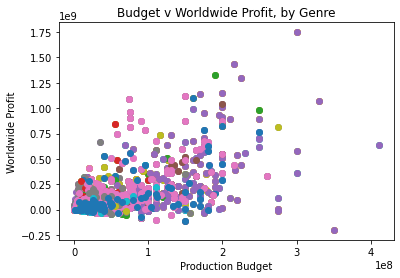

In [63]:
fig = plt.figure()
ax = plt.subplot(111)


for genre,frame in genres_df.items():
    ax = plt.scatter(frame['production_budget'], frame['worldwide_profit'], label=genre)

plt.title('Budget v Worldwide Profit, by Genre')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Profit');

In [64]:
money_genre['production_budget'].corr(money_genre['worldwide_profit'])

0.6528359616947517

With a corr of 0.653, we can see that spending more on a movie's budget generally leads to greater returns in the form of worldwide profit.

I'd like to dig more into each genre, and each production cost bucket(low/med/high) to provide a single best answer for: "What is the most likely profitable movie genre based on a given budget?"

#### Find corr of production cost vs revenue for each genre
- Note: outliers are not excluded

In [65]:
genres_corr = []
for genre,frame in genres_df.items():
    corr = frame['production_budget'].corr(frame['worldwide_profit'])
    genres_corr.append(tuple((genre, corr)))
#     print(f"{genre}: has a corr of {corr}")

        
# Sort list of tuples
genres_corr.sort(key = lambda x: x[1], reverse=True)



# Create list for genres, and list for corrs
genres_corrx = [x[0] for x in genres_corr]
genres_corry = [x[1] for x in genres_corr]

# Slice top 5 options for clarity
genres_corrx = genres_corrx[:5]
genres_corry = genres_corry[:5]


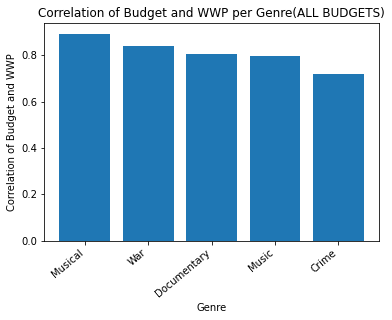

In [66]:
plt.bar(genres_corrx, genres_corry)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Genre')
plt.ylabel('Correlation of Budget and WWP')
plt.title('Correlation of Budget and WWP per Genre(ALL BUDGETS)');

In [67]:
genres_df['Musical'].sort_values(['worldwide_profit'], ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin,name_year,primary_title,genres,start_year,genres_list
134,35,2017-03-17,Beauty and the Beast,160000000,504014165,1259199706,344014165,1099199706,0.682549,0.872935,Beauty and the Beast2017,Beauty and the Beast,"Family,Fantasy,Musical",2017,"[Family,Fantasy,Musical]"
50,51,2010-03-05,Alice in Wonderland,200000000,334191110,1025491110,134191110,825491110,0.401540,0.804971,Alice in Wonderland2010,Alice in Wonderland,"Fantasy,Musical",2010,"[Fantasy,Musical]"
524,25,2017-12-20,The Greatest Showman,84000000,174340174,386665550,90340174,302665550,0.518183,0.782758,The Greatest Showman2017,The Greatest Showman,"Biography,Drama,Musical",2017,"[Biography,Drama,Musical]"
3853,54,2013-05-31,Yeh Jawaani Hai Deewani,8300000,3827466,50827466,-4472534,42527466,-1.168537,0.836702,Yeh Jawaani Hai Deewani2013,Yeh Jawaani Hai Deewani,"Comedy,Drama,Musical",2013,"[Comedy,Drama,Musical]"
1023,24,2010-11-24,Burlesque,55000000,39440655,90552675,-15559345,35552675,-0.394500,0.392619,Burlesque2010,Burlesque,"Drama,Music,Musical",2010,"[Drama,Music,Musical]"
4973,74,2012-10-26,The Ghastly Love of Johnny X,2000000,2436,2436,-1997564,-1997564,-820.018062,-820.018062,The Ghastly Love of Johnny X2012,The Ghastly Love of Johnny X,"Comedy,Fantasy,Musical",2012,"[Comedy,Fantasy,Musical]"
4210,11,2010-07-16,Standing Ovation,5600000,531806,531806,-5068194,-5068194,-9.530156,-9.530156,Standing Ovation2010,Standing Ovation,Musical,2010,[Musical]
728,29,2012-06-15,Rock of Ages,70000000,38518613,61031932,-31481387,-8968068,-0.817303,-0.146941,Rock of Ages2012,Rock of Ages,"Comedy,Drama,Musical",2012,"[Comedy,Drama,Musical]"


#### Surprisingly, the musical genre has the greatest likelihood to convert budget to revenue.

We can now split every genre into low/med/high budget, and then graph their correlation of budget vs worldwide profit.

In [68]:
# Group low/med/high budget genres
# genres_df is dict where key = genre, value = df of movies with that genre
genres_df_low = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget < 5000000)] for x in unique_genres}
genres_df_med = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget > 5000000) & 
                                (money_genre.production_budget < 50000000)] for x in unique_genres}
genres_df_high = {x: money_genre[(money_genre.genres.str.contains(x)) & 
                                (money_genre.production_budget > 50000000)] for x in unique_genres}


Creating correlations for every budget bucket.
Note:
- Some outliers have been filtered out.
- Only genres with 3+ movies have been considered.
- Have to make a tuple of (genre,corr) to sort, then unpack into lists for graphing

Western only had 2 movies.
Animation only had 1 movies.
History only had 1 movies.
Musical only had 1 movies.
War only had 2 movies.


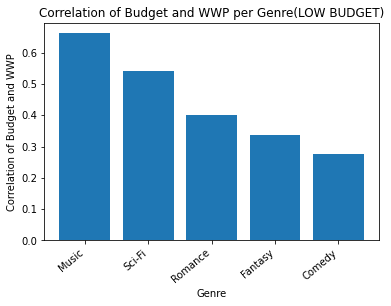

In [71]:
genres_corr_low = []
for genre,frame in genres_df_low.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_low.append(tuple((genre, corr)))
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")

        
# Sort list of tuples
genres_corr_low.sort(key = lambda x: x[1], reverse=True)

# Create list for genres, and list for corrs
genres_corr_lowx = [x[0] for x in genres_corr_low]
genres_corr_lowy = [x[1] for x in genres_corr_low]

# Slice top 5 options for clarity
genres_corr_lowx = genres_corr_lowx[:5]
genres_corr_lowy = genres_corr_lowy[:5]

plt.bar(genres_corr_lowx, genres_corr_lowy)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Genre')
plt.ylabel('Correlation of Budget and WWP')
plt.title('Correlation of Budget and WWP per Genre(LOW BUDGET)');

In [79]:
genres_df_low['Music'].sort_values(['worldwide_profit'], ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin,name_year,primary_title,genres,start_year,genres_list
4642,43,2014-10-10,Whiplash,3300000,13092006,38969037,9792006,35669037,0.747938,0.915317,Whiplash2014,Whiplash,"Drama,Music",2014,"[Drama,Music]"
4597,98,2018-01-19,Forever My Girl,3500000,16376066,16376066,12876066,12876066,0.786273,0.786273,Forever My Girl2018,Forever My Girl,"Drama,Music,Romance",2018,"[Drama,Music,Romance]"
5010,11,2013-02-08,ABCD (Any Body Can Dance),1900000,222098,10137234,-1677902,8237234,-7.554782,0.812572,ABCD (Any Body Can Dance)2013,ABCD (Any Body Can Dance),"Drama,Music",2013,"[Drama,Music]"
4919,20,2015-08-28,We Are Your Friends,2000000,3591417,10153415,1591417,8153415,0.443117,0.803022,We Are Your Friends2015,We Are Your Friends,"Drama,Music,Romance",2015,"[Drama,Music,Romance]"
5042,43,2013-10-04,Grace Unplugged,1700000,2507159,2507159,807159,807159,0.321942,0.321942,Grace Unplugged2013,Grace Unplugged,"Drama,Music",2013,"[Drama,Music]"
5255,56,2017-08-18,Patti Cake$,1000000,800148,1471090,-199852,471090,-0.249769,0.320232,Patti Cake$2017,Patti Cake$,"Drama,Music",2017,"[Drama,Music]"
4924,25,2018-06-08,Hearts Beat Loud,2000000,2386254,2420962,386254,420962,0.161866,0.173882,Hearts Beat Loud2018,Hearts Beat Loud,"Comedy,Drama,Music",2018,"[Comedy,Drama,Music]"
5689,90,2014-06-19,The Past is a Grotesque Animal,100000,20056,20056,-79944,-79944,-3.986039,-3.986039,The Past is a Grotesque Animal2014,The Past is a Grotesque Animal,"Biography,Documentary,Music",2014,"[Biography,Documentary,Music]"
5557,58,2015-10-23,The Looking Glass,300000,1711,1711,-298289,-298289,-174.336061,-174.336061,The Looking Glass2015,The Looking Glass,"Drama,Music",2015,"[Drama,Music]"
4972,73,2013-09-13,Plush,2000000,3080,28864,-1996920,-1971136,-648.350649,-68.290466,Plush2013,Plush,"Drama,Music,Thriller",2013,"[Drama,Music,Thriller]"


Musical only had 2 movies.


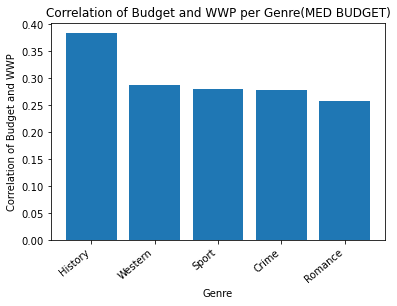

In [72]:
genres_corr_med = []
for genre,frame in genres_df_med.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_med.append(tuple((genre, corr)))
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")

# Sort list of tuples
genres_corr_med.sort(key = lambda x: x[1], reverse=True)

# Create list for genres, and list for corrs
genres_corr_medx = [x[0] for x in genres_corr_med]
genres_corr_medy = [x[1] for x in genres_corr_med]

# Slice top 5 options for clarity
genres_corr_medx = genres_corr_medx[:5]
genres_corr_medy = genres_corr_medy[:5]

plt.bar(genres_corr_medx, genres_corr_medy)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Genre')
plt.ylabel('Correlation of Budget and WWP')
plt.title('Correlation of Budget and WWP per Genre(MED BUDGET)') ;

In [73]:
genres_df_med['History'].sort_values(['worldwide_profit'], ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin,name_year,primary_title,genres,start_year,genres_list
2163,64,2016-12-25,Hidden Figures,25000000,169607287,231771716,144607287,206771716,0.852601,0.892135,Hidden Figures2016,Hidden Figures,"Biography,Drama,History",2016,"[Biography,Drama,History]"
2034,35,2015-08-14,Straight Outta Compton,28000000,161197785,202182981,133197785,174182981,0.826300,0.861512,Straight Outta Compton2015,Straight Outta Compton,"Biography,Drama,History",2015,"[Biography,Drama,History]"
2517,18,2013-10-18,12 Years a Slave,20000000,56671993,181025343,36671993,161025343,0.647092,0.889518,12 Years a Slave2013,12 Years a Slave,"Biography,Drama,History",2013,"[Biography,Drama,History]"
1499,100,2012-12-21,The Impossible,40000000,19019882,169590606,-20980118,129590606,-1.103062,0.764138,The Impossible2012,The Impossible,"Drama,History,Thriller",2012,"[Drama,History,Thriller]"
1416,17,2016-11-04,Hacksaw Ridge,40000000,67209615,168904682,27209615,128904682,0.404847,0.763180,Hacksaw Ridge2016,Hacksaw Ridge,"Biography,Drama,History",2016,"[Biography,Drama,History]"
1409,10,2015-10-16,Bridge of Spies,40000000,72313754,162498338,32313754,122498338,0.446855,0.753844,Bridge of Spies2015,Bridge of Spies,"Drama,History,Thriller",2015,"[Drama,History,Thriller]"
1883,84,2017-11-22,Darkest Hour,30000000,56443120,150807172,26443120,120807172,0.468491,0.801070,Darkest Hour2017,Darkest Hour,"Biography,Drama,History",2017,"[Biography,Drama,History]"
3038,39,2018-11-23,The Favourite,15000000,34366783,94113929,19366783,79113929,0.563532,0.840619,The Favourite2018,The Favourite,"Biography,Drama,History",2018,"[Biography,Drama,History]"
2410,11,2014-02-28,Son of God,22000000,59700064,70949793,37700064,48949793,0.631491,0.689922,Son of God2014,Son of God,"Biography,Drama,History",2014,"[Biography,Drama,History]"
3480,81,2015-04-01,Woman in Gold,11000000,33307793,58586407,22307793,47586407,0.669747,0.812243,Woman in Gold2015,Woman in Gold,"Biography,Drama,History",2015,"[Biography,Drama,History]"


In [74]:
# Create list of tuples. [0]=genre, [1]=corr
genres_corr_high = []
for genre,frame in genres_df_high.items():
    if len(frame.index) >= 3:
        corr = frame['production_budget'].corr(frame['worldwide_profit'])
        genres_corr_high.append(tuple((genre, corr)))
#         print(f"{genre}: {corr}")
    else:
        print(f"{genre} only had {len(frame.index)} movies.")

In [75]:
# Sort list of tuples
genres_corr_high.sort(key = lambda x: x[1], reverse=True)

In [76]:
# Create list for genres, and list for corrs
genres_corr_highx = [x[0] for x in genres_corr_high]
genres_corr_highy = [x[1] for x in genres_corr_high]

# Slice top 5 options for clarity
genres_corr_highx = genres_corr_highx[:5]
genres_corr_highy = genres_corr_highy[:5]

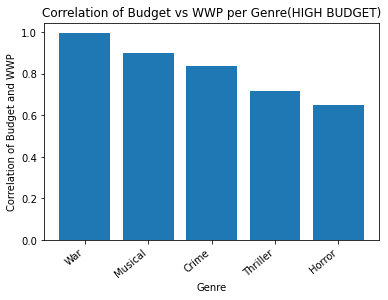

In [77]:
plt.bar(genres_corr_highx, genres_corr_highy)
plt.xticks(rotation=40, ha='right')
plt.xlabel('Genre')
plt.ylabel('Correlation of Budget and WWP')
plt.title('Correlation of Budget vs WWP per Genre(HIGH BUDGET)') ;

In [78]:
genres_df_high['War'].sort_values(['worldwide_profit'], ascending=False).head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,domestic_margin,worldwide_margin,name_year,primary_title,genres,start_year,genres_list
325,26,2014-03-07,300: Rise of an Empire,110000000,106580051,330780051,-3419949,220780051,-0.032088,0.667453,300: Rise of an Empire2014,300: Rise of an Empire,"Action,Fantasy,War",2014,"[Action,Fantasy,War]"
567,68,2014-10-17,Fury,80000000,85817906,210315681,5817906,130315681,0.067794,0.619619,Fury2014,Fury,"Action,Drama,War",2014,"[Action,Drama,War]"
711,12,2011-12-25,War Horse,70000000,79883359,156815529,9883359,86815529,0.123722,0.553616,War Horse2011,War Horse,"Drama,History,War",2011,"[Drama,History,War]"


Based on these observations, we can now recommend genres that are most likely to generate profit from budget at stratified spending amounts.
- For a low budget production(sub 5 million dollars), we recommend creating a music movie.
- For a medium budget production(between 5 and 50 million dollars), we recommend creating a history movie.
- For a high budget production(over 50 million dollars), we recommend creating a war movie.
